In [24]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import scipy.stats as sts
import quandl
import os
from config import api_key
import numpy as np
from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

In [2]:
# Importing Quandl data using the API

In [25]:
try:
    B_Spread = quandl.get("ML/BEY", authtoken=api_key)
    Treasury_curve = quandl.get("USTREASURY/YIELD", authtoken=api_key)
    SP_500 = quandl.get("CHRIS/CME_ES2")
except Exception as e:
    print(e)

## S&P500 DataFrame

In [26]:
SP_500.reset_index(inplace=True)
SP_500

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
0,1997-09-09,943.50,951.00,941.50,944.00,NaN,944.00,896.0,273.0
1,1997-09-10,942.75,943.25,917.00,925.00,NaN,925.00,12261.0,382.0
2,1997-09-11,924.00,929.75,910.25,918.25,NaN,918.25,9759.0,2909.0
3,1997-09-12,918.00,936.50,913.50,933.75,NaN,933.75,18496.0,4059.0
4,1997-09-15,933.50,939.75,929.00,931.50,NaN,931.50,11749.0,3818.0
...,...,...,...,...,...,...,...,...,...
5789,2020-06-09,3216.00,3220.00,3179.00,3194.50,22.25,3194.50,92923.0,127169.0
5790,2020-06-10,3194.25,3216.75,3168.75,3173.50,19.00,3175.50,160381.0,151588.0
5791,2020-06-11,3173.00,3177.75,2985.25,3003.00,176.00,2999.50,802407.0,193508.0
5792,2020-06-12,3000.75,3076.75,2971.00,3024.50,24.25,3023.75,2715442.0,414547.0


In [27]:
# Sub data frame with Settle Price only
SP500_Price_df = pd.DataFrame({'Date': SP_500['Date'],
                               'Closing Price': SP_500['Settle']
                              })
SP500_Price_df

,Date,Closing Price
0,1997-09-09,944.00
1,1997-09-10,925.00
2,1997-09-11,918.25
3,1997-09-12,933.75
4,1997-09-15,931.50
...,...,...
5789,2020-06-09,3194.50
5790,2020-06-10,3175.50
5791,2020-06-11,2999.50
5792,2020-06-12,3023.75


## Resetting B Spread dataframe 

In [28]:
B_Spread.reset_index(inplace=True)
B_Spread.columns = ['Date','B Rating']
B_Spread

,Date,B Rating
0,1996-12-31,10.01
1,1997-01-02,10.00
2,1997-01-03,10.01
3,1997-01-06,10.05
4,1997-01-07,10.07
...,...,...
6116,2020-06-09,6.23
6117,2020-06-10,6.34
6118,2020-06-11,6.83
6119,2020-06-12,6.73


In [29]:
# Convert to datetime object
B_Spread['Date'] = pd.to_datetime(B_Spread['Date'])

In [30]:
# Filter dates
New_B_Spread = B_Spread.loc[(B_Spread['Date']>='1997-09-09')]
New_B_Spread

,Date,B Rating
176,1997-09-09,9.59
177,1997-09-10,9.58
178,1997-09-11,9.60
179,1997-09-12,9.58
180,1997-09-15,9.55
...,...,...
6116,2020-06-09,6.23
6117,2020-06-10,6.34
6118,2020-06-11,6.83
6119,2020-06-12,6.73


## Treasury Curve DataFrame

In [31]:
# Resetting the index
Treasury_curve = Treasury_curve.reset_index()

In [32]:
# Converting to datetime objects 
Treasury_curve['Date'] = pd.to_datetime(Treasury_curve['Date'])
Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
0,1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1,1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
2,1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
3,1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
4,1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7615,2020-06-10,0.13,0.16,0.17,0.19,0.18,0.17,0.22,0.33,0.56,0.75,1.31,1.53
7616,2020-06-11,0.14,0.16,0.17,0.18,0.19,0.19,0.22,0.32,0.51,0.66,1.19,1.41
7617,2020-06-12,0.14,0.15,0.16,0.18,0.18,0.19,0.22,0.33,0.54,0.71,1.24,1.45
7618,2020-06-15,0.15,0.16,0.18,0.19,0.17,0.19,0.22,0.33,0.54,0.71,1.24,1.45


In [33]:
# Filtering the dates to match S&P500
New_Treasury_curve = Treasury_curve.loc[(Treasury_curve['Date']>='1997-09-09')]
New_Treasury_curve

,Date,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
1924,1997-09-09,NaN,NaN,5.16,5.35,5.60,5.98,6.09,6.24,6.33,6.34,6.70,6.63
1925,1997-09-10,NaN,NaN,5.11,5.35,5.61,6.00,6.10,6.26,6.36,6.37,6.71,6.66
1926,1997-09-11,NaN,NaN,5.13,5.36,5.59,6.00,6.11,6.27,6.38,6.39,6.75,6.68
1927,1997-09-12,NaN,NaN,5.10,5.32,5.54,5.93,6.03,6.17,6.28,6.29,6.66,6.59
1928,1997-09-15,NaN,NaN,5.08,5.31,5.54,5.93,6.02,6.17,6.28,6.28,6.65,6.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7615,2020-06-10,0.13,0.16,0.17,0.19,0.18,0.17,0.22,0.33,0.56,0.75,1.31,1.53
7616,2020-06-11,0.14,0.16,0.17,0.18,0.19,0.19,0.22,0.32,0.51,0.66,1.19,1.41
7617,2020-06-12,0.14,0.15,0.16,0.18,0.18,0.19,0.22,0.33,0.54,0.71,1.24,1.45
7618,2020-06-15,0.15,0.16,0.18,0.19,0.17,0.19,0.22,0.33,0.54,0.71,1.24,1.45


In [34]:
# Final Treasury DataFrame
Treasury_5_Year = pd.DataFrame({'Date': New_Treasury_curve['Date'],
                                '5 Year Rate': New_Treasury_curve['5 YR']
                               })
Treasury_5_Year

,Date,5 Year Rate
1924,1997-09-09,6.24
1925,1997-09-10,6.26
1926,1997-09-11,6.27
1927,1997-09-12,6.17
1928,1997-09-15,6.17
...,...,...
7615,2020-06-10,0.33
7616,2020-06-11,0.32
7617,2020-06-12,0.33
7618,2020-06-15,0.33


## Merging DataFrames

In [35]:
SP500_BondSpread_df = pd.merge(SP500_Price_df,New_B_Spread, on='Date')

In [36]:
SP500_BondSpread_df

,Date,Closing Price,B Rating
0,1997-09-09,944.00,9.59
1,1997-09-10,925.00,9.58
2,1997-09-11,918.25,9.60
3,1997-09-12,933.75,9.58
4,1997-09-15,931.50,9.55
...,...,...,...
5779,2020-06-09,3194.50,6.23
5780,2020-06-10,3175.50,6.34
5781,2020-06-11,2999.50,6.83
5782,2020-06-12,3023.75,6.73


In [37]:
# Final DataFrame
Final_Market_Data_df = pd.merge(SP500_BondSpread_df,Treasury_5_Year,on='Date')

In [38]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate
0,1997-09-09,944.00,9.59,6.24
1,1997-09-10,925.00,9.58,6.26
2,1997-09-11,918.25,9.60,6.27
3,1997-09-12,933.75,9.58,6.17
4,1997-09-15,931.50,9.55,6.17
...,...,...,...,...
5680,2020-06-09,3194.50,6.23,0.40
5681,2020-06-10,3175.50,6.34,0.33
5682,2020-06-11,2999.50,6.83,0.32
5683,2020-06-12,3023.75,6.73,0.33


## DataFrame Calculations
- Calculate the Credit Spread (B rated yields - 5Yr Treasury Rate)
- Calculate the SP500, B rating yield and 5Yr Treasruy returns

In [39]:
# Yield Spread Calculation
Final_Market_Data_df['Yield Spread'] = Final_Market_Data_df['B Rating'] - Final_Market_Data_df['5 Year Rate']

# Calculating S&P500 Returns
Final_Market_Data_df['S&P 500 Returns'] = Final_Market_Data_df['Closing Price'].pct_change()

# Calculating Yield Spread Returns
Final_Market_Data_df['Yield Spread Returns'] = Final_Market_Data_df['Yield Spread'].pct_change()

In [40]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798
...,...,...,...,...,...,...,...
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897


Text(0.5, 1.0, 'Junk Bond vs 5 Year Treasury Spread')

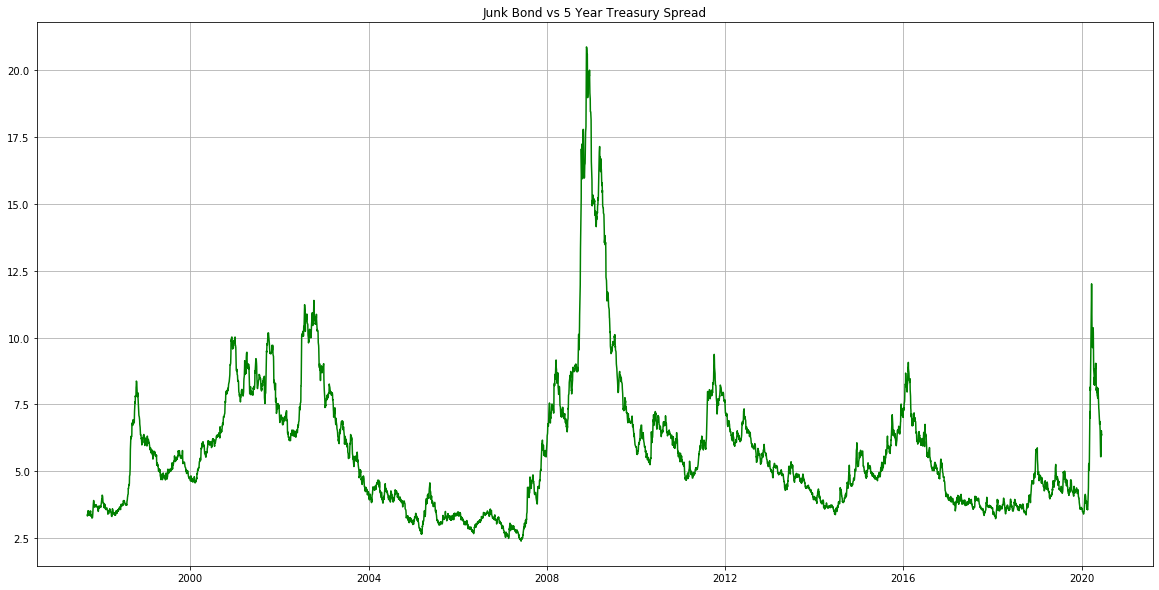

In [41]:
# Plotting the Spread
fig = plt.figure(figsize = (20,10))

plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Yield Spread'],'-g', label="Yield Spread")
plt.grid(True)
plt.title('Junk Bond vs 5 Year Treasury Spread')

## Correlation/Z-Score Parameters

In [42]:
# Correlation
Rolling_window = 55

Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] = Final_Market_Data_df['S&P 500 Returns'].rolling(window=Rolling_window).corr(Final_Market_Data_df['Yield Spread Returns'])
Final_Market_Data_df

# Standard derviation
Final_Market_Data_df[str(Rolling_window)+ 'Day std'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).std()
Final_Market_Data_df

# Rolling Mean
Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'] = Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'].rolling(Rolling_window).mean()

# Rolling Z-Score
Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'] = ((Final_Market_Data_df['Correl'+ str(Rolling_window) + 'day'] - Final_Market_Data_df[str(Rolling_window)+ 'Day Mean'])/Final_Market_Data_df[str(Rolling_window)+ 'Day std'])


In [43]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347,-0.472650,0.068124,-0.678796,3.026050
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875,-0.439552,0.074750,-0.673237,3.126240
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195,-0.526273,0.076836,-0.669455,1.863470
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897,-0.525355,0.078715,-0.665658,1.782420


## Z-Score/Correl Plots

Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

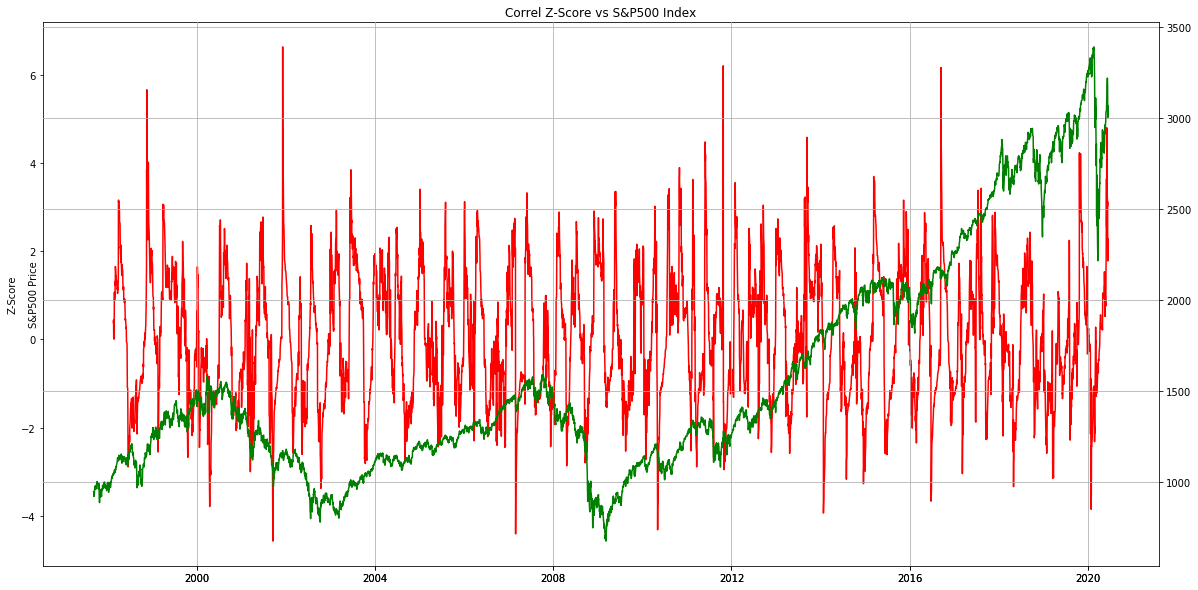

In [44]:
# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('Correlation Z-Score ')

# Generating the chart
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(Final_Market_Data_df['Date'],Final_Market_Data_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')


In [ ]:
# Plotting the S&P500

# fig = plt.figure(figsize = (20,10))

# plt.plot(Final_Market_Data_df['Date'],Final_Market_Data_df['Closing Price'],'-g', label="Z-Score")
# plt.grid(True)
# plt.title('S&P500')

In [47]:
My_market_data_df = Final_Market_Data_df

## Signal Function

In [58]:
def my_signal(row):
    if row[str(Rolling_window)+ 'Z-Score']>=2.5:
        return row[str(Rolling_window)+ 'Z-Score']
    elif row[str(Rolling_window)+ 'Z-Score'] <=-2.5:
        return row[str(Rolling_window)+ 'Z-Score']
    else:
        return 0
    
My_market_data_df['signal'] = My_market_data_df.apply(my_signal, axis=1)

In [59]:
My_market_data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,signal
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN,0.00000
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN,0.00000
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN,0.00000
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN,0.00000
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347,-0.472650,0.068124,-0.678796,3.026050,3.02605
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875,-0.439552,0.074750,-0.673237,3.126240,3.12624
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195,-0.526273,0.076836,-0.669455,1.863470,0.00000
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897,-0.525355,0.078715,-0.665658,1.782420,0.00000


In [68]:
My_market_data_df.to_csv('final_market_data.csv', encoding = 'utf-8')

Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

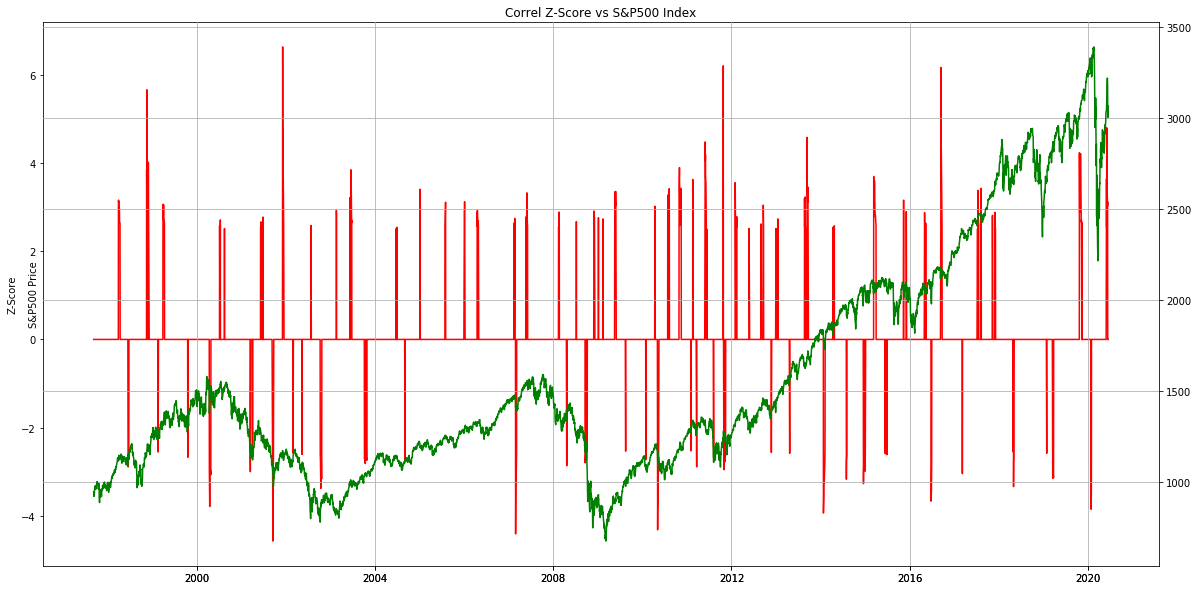

In [60]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(My_market_data_df['Date'],My_market_data_df['signal'],'-r', label="Z-Score Signal")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(My_market_data_df['Date'],My_market_data_df['Closing Price'],'-g', label="SP500")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

In [45]:
Final_Market_Data_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,0.052347,-0.472650,0.068124,-0.678796,3.026050
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,0.030875,-0.439552,0.074750,-0.673237,3.126240
5682,2020-06-11,2999.50,6.83,0.32,6.51,-0.055424,0.083195,-0.526273,0.076836,-0.669455,1.863470
5683,2020-06-12,3023.75,6.73,0.33,6.40,0.008085,-0.016897,-0.525355,0.078715,-0.665658,1.782420


## 1997-2003

In [61]:
# Data Frame inputs
ltcm_df = My_market_data_df.loc[(My_market_data_df['Date']>='1997-09-09') & (My_market_data_df['Date']<='2003-12-31')]
ltcm_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,signal
0,1997-09-09,944.00,9.59,6.24,3.35,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1997-09-10,925.00,9.58,6.26,3.32,-0.020127,-0.008955,NaN,NaN,NaN,NaN,0.0
2,1997-09-11,918.25,9.60,6.27,3.33,-0.007297,0.003012,NaN,NaN,NaN,NaN,0.0
3,1997-09-12,933.75,9.58,6.17,3.41,0.016880,0.024024,NaN,NaN,NaN,NaN,0.0
4,1997-09-15,931.50,9.55,6.17,3.38,-0.002410,-0.008798,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1570,2003-12-24,1091.75,7.41,3.20,4.21,-0.000686,0.024331,-0.178088,0.074057,-0.318871,1.901016,0.0
1571,2003-12-26,1092.50,7.41,3.17,4.24,0.000687,0.007126,-0.191506,0.071799,-0.319906,1.788315,0.0
1572,2003-12-29,1106.75,7.41,3.23,4.18,0.013043,-0.014151,-0.198413,0.071640,-0.319996,1.697118,0.0
1573,2003-12-30,1106.75,7.40,3.26,4.14,0.000000,-0.009569,-0.199601,0.071989,-0.319781,1.669430,0.0


Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

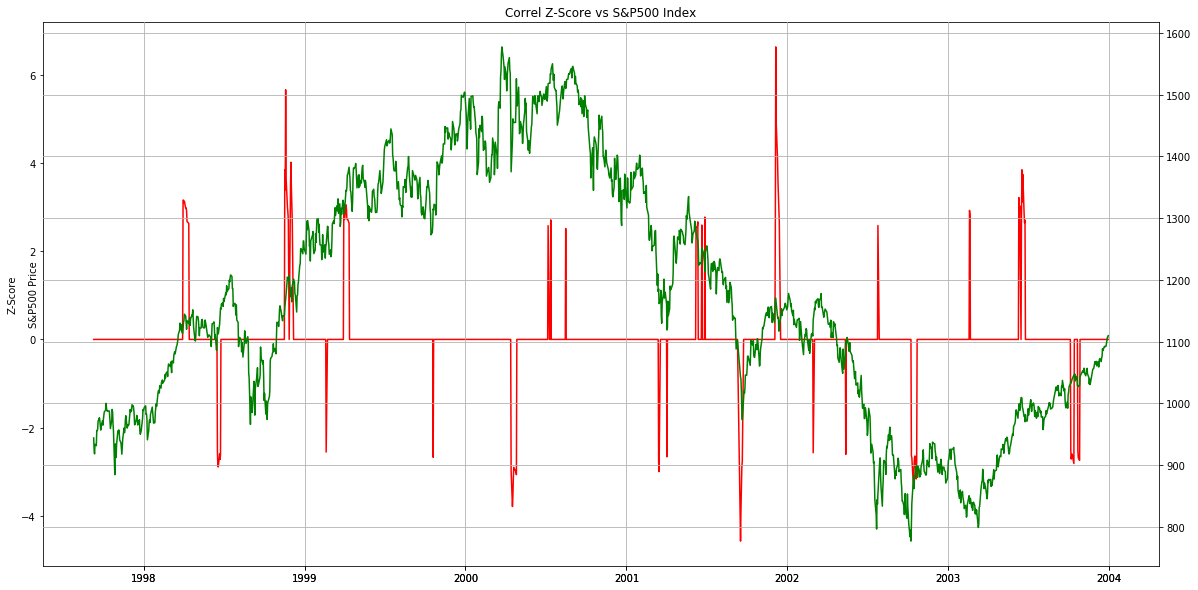

In [62]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(ltcm_df['Date'],ltcm_df['signal'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(ltcm_df['Date'],ltcm_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## Saving to csv

In [63]:
ltcm_df.to_csv("LTCM_period.csv",encoding='utf-8' )

## 2004-2009

In [64]:
financial_crisis_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2004-01-01') & (Final_Market_Data_df['Date']<='2009-12-31')]
financial_crisis_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,signal
1575,2004-01-02,1108.00,7.46,3.36,4.10,-0.001577,-2.843602e-02,-0.173994,0.074141,-0.318506,1.949150,0.0
1576,2004-01-05,1119.25,7.38,3.39,3.99,0.010153,-2.682927e-02,-0.185518,0.075628,-0.317448,1.744454,0.0
1577,2004-01-06,1121.25,7.29,3.26,4.03,0.001787,1.002506e-02,-0.207270,0.076267,-0.316954,1.438170,0.0
1578,2004-01-07,1124.75,7.21,3.25,3.96,0.003122,-1.736973e-02,-0.201463,0.077143,-0.316269,1.488218,0.0
1579,2004-01-08,1128.50,7.16,3.24,3.92,0.003334,-1.010101e-02,-0.182516,0.078645,-0.315147,1.686453,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3071,2009-12-24,1117.25,8.56,2.57,5.99,0.005626,-1.317957e-02,-0.403430,0.049077,-0.444276,0.832287,0.0
3072,2009-12-28,1118.50,8.56,2.62,5.94,0.001119,-8.347245e-03,-0.389245,0.048229,-0.441740,1.088458,0.0
3073,2009-12-29,1117.00,8.54,2.62,5.92,-0.001341,-3.367003e-03,-0.402666,0.047292,-0.439608,0.781157,0.0
3074,2009-12-30,1117.50,8.53,2.61,5.92,0.000448,2.220446e-16,-0.393069,0.045805,-0.437012,0.959354,0.0


Text(0.5, 1.0, 'Correl Z-Score vs S&P500 Index')

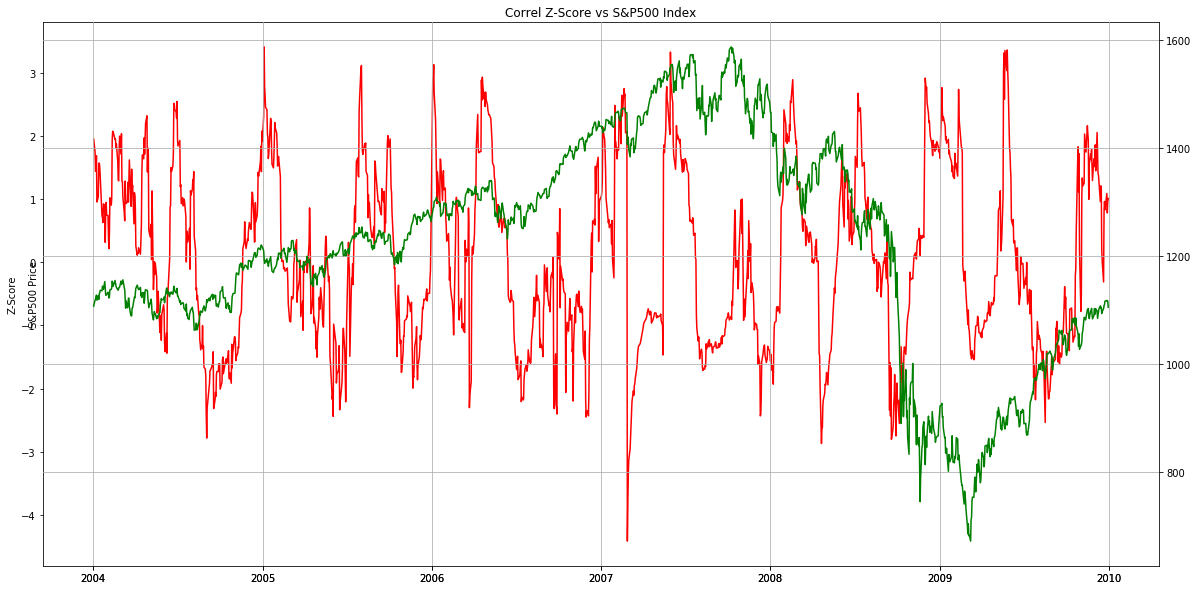

In [67]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(financial_crisis_df['Date'],financial_crisis_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(financial_crisis_df['Date'],financial_crisis_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2010-2015

In [65]:
recovery_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2010-01-01') & (Final_Market_Data_df['Date']<='2015-12-31')]
recovery_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,signal
3076,2010-01-04,1124.00,8.56,2.65,5.91,0.016275,0.001695,-0.368800,0.045254,-0.432524,1.408132,0.0
3077,2010-01-05,1127.50,8.43,2.56,5.87,0.003114,-0.006768,-0.340502,0.045269,-0.429245,1.960353,0.0
3078,2010-01-06,1128.00,8.34,2.60,5.74,0.000443,-0.022147,-0.331132,0.045272,-0.425742,2.089805,0.0
3079,2010-01-07,1132.50,8.26,2.62,5.64,0.003989,-0.017422,-0.327397,0.044572,-0.421940,2.121113,0.0
3080,2010-01-08,1136.75,8.22,2.57,5.65,0.003753,0.001773,-0.327248,0.043692,-0.418194,2.081534,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4568,2015-12-24,2044.50,8.86,1.73,7.13,-0.000977,-0.001401,-0.468248,0.051142,-0.487454,0.375543,0.0
4569,2015-12-28,2042.25,8.87,1.73,7.14,-0.001101,0.001403,-0.478038,0.050585,-0.486275,0.162840,0.0
4570,2015-12-29,2066.25,8.84,1.81,7.03,0.011752,-0.015406,-0.475976,0.049844,-0.484934,0.179719,0.0
4571,2015-12-30,2048.00,8.81,1.80,7.01,-0.008832,-0.002845,-0.462504,0.048961,-0.483234,0.423386,0.0


In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(recovery_df['Date'],recovery_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(recovery_df['Date'],recovery_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## 2016-2020

In [66]:
latest_df = Final_Market_Data_df.loc[(Final_Market_Data_df['Date']>='2016-01-01') & (Final_Market_Data_df['Date']<='2020-06-11')]
latest_df

,Date,Closing Price,B Rating,5 Year Rate,Yield Spread,S&P 500 Returns,Yield Spread Returns,Correl55day,55Day std,55Day Mean,55Z-Score,signal
4573,2016-01-04,2002.00,9.10,1.73,7.37,-0.013064,2.361111e-02,-0.493277,0.047334,-0.481109,-0.257076,0.000000
4574,2016-01-05,2004.75,9.01,1.73,7.28,0.001374,-1.221167e-02,-0.490637,0.046411,-0.480035,-0.228447,0.000000
4575,2016-01-06,1978.75,9.02,1.65,7.37,-0.012969,1.236264e-02,-0.494860,0.045549,-0.479092,-0.346183,0.000000
4576,2016-01-07,1925.50,9.13,1.61,7.52,-0.026911,2.035278e-02,-0.505191,0.044834,-0.478396,-0.597655,0.000000
4577,2016-01-08,1904.25,9.09,1.57,7.52,-0.011036,-1.110223e-16,-0.497890,0.043954,-0.477522,-0.463397,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5678,2020-06-05,3176.50,6.01,0.47,5.54,0.024760,-6.576728e-02,-0.481326,0.057070,-0.688443,3.629167,3.629167
5679,2020-06-08,3216.75,5.99,0.45,5.54,0.012671,0.000000e+00,-0.488649,0.062485,-0.683701,3.121583,3.121583
5680,2020-06-09,3194.50,6.23,0.40,5.83,-0.006917,5.234657e-02,-0.472650,0.068124,-0.678796,3.026050,3.026050
5681,2020-06-10,3175.50,6.34,0.33,6.01,-0.005948,3.087479e-02,-0.439552,0.074750,-0.673237,3.126240,3.126240


In [ ]:
fig1 = plt.figure(figsize = (20,10))

ax3 = fig1.add_subplot(111)
line3 = ax3.plot(latest_df['Date'],latest_df[str(Rolling_window)+ 'Z-Score'],'-r', label="Z-Score")
plt.ylabel("Z-Score")

ax4 = fig1.add_subplot(111, sharex=ax3, frameon=False)
line4 = ax4.plot(latest_df['Date'],latest_df['Closing Price'],'-g', label="Z-Score")
ax4.yaxis.tick_right()
plt.ylabel('S&P500 Price')

plt.grid(True)
plt.title('Correl Z-Score vs S&P500 Index')

## Yield Spread Ratio Analysis

In [ ]:
Ratio_df = Final_Market_Data_df

In [ ]:
# Calculate the Junk Bond to Treasury Yield Ratio
Ratio_df['Junk/Treasury'] = Ratio_df['B Rating'] / Ratio_df['5 Year Rate']

In [ ]:
# Calculate the historical Volatilities of the ratio
vol_window = [21,55,100]
daily_vol = np.sqrt(252)

for vol in vol_window:
    Ratio_df[str(vol) + 'day vol'] = Ratio_df['Junk/Treasury'].rolling(vol).std()*daily_vol


In [ ]:
print(daily_vol)
print(np.sqrt(252))

In [ ]:
Ratio_df.head(100)

In [ ]:
# Scatter Plot
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Yield Spread Returns'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Yield Spread Return vs S&P500 Returns Scatter')
plt.xlabel('S&P500 Returns')
plt.ylabel('Yield Spread Returns')

## Correlation S&P500 Returns vs Yield Spread Returns

In [ ]:
# Correlation
x = Ratio_df['Yield Spread Returns'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

## Linear Regression S&P500 Returns vs Yield Spread Returns

In [ ]:
# Variables for the regression
x_values = Ratio_df['Yield Spread Returns'].dropna()
y_values = Ratio_df['S&P 500 Returns'].dropna()

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)

regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,1)) + "x + " + str(round(intercept,1))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.002, 0),fontsize=15,color="red")
plt.xlabel('Yield Spread Return')
plt.ylabel("S&P 500 Returns")

print(f"rvalue    = {round(rvalue, 3)}")
print(f"r-squared = {round(rvalue**2, 3)}")

plt.show()

In [ ]:
Ratio_df['S&P 500 Returns'].hist()

In [ ]:
Ratio_df['Yield Spread Returns'].hist()

In [ ]:
x = Ratio_df['Yield Spread']
x

In [ ]:
x.diff(periods=1)

## Adding Yield Spread Absolute Change

In [ ]:
Ratio_df['Change in bps'] = Ratio_df['Yield Spread'].diff(periods=1)*100

In [ ]:
Ratio_df

In [ ]:
fig = plt.figure(figsize = (20,10))

plt.scatter(x = Ratio_df['Change in bps'],
            y = Ratio_df['S&P 500 Returns'])
plt.grid(True)
plt.title('Scatter Plot S&P500 Returns vs Yield Spread Absolute Change')
plt.xlabel('Change in bps')
plt.ylabel('S&P 500 Returns')

In [ ]:
# Correlation
x = Ratio_df['Change in bps'].dropna()
y = Ratio_df['S&P 500 Returns'].dropna()

print(pearsonr(x,y))

In [ ]:
# Plotting the Spread
fig = plt.figure(figsize = (20,10))

plt.plot(Ratio_df['Date'],Ratio_df['Change in bps'],'-g', label="Yield Spread")
plt.grid(True)
plt.title('Spread Change in bps')



## Adding SP500 Historical Vol

In [ ]:
Ratio_df

In [ ]:
# Calculate the historical Volatilities of the ratio
vol_window = [21,55,100]
daily_vol = np.sqrt(252)

for vol in vol_window:
    Ratio_df[str(vol) + 'day vol'] = Ratio_df['Junk/Treasury'].rolling(vol).std()*daily_vol